# Feature Engineering

## Was ist Feature Engineering?

Feature Engineering ist der Prozess, bei dem Rohdaten mithilfe von Fachwissen und statistischen Methoden in **Merkmale (Features)** umgewandelt werden, die von einem Machine-Learning-Modell bestmöglich verstanden und genutzt werden können. Es ist oft der kreativste und gleichzeitig einer der wirkungsvollsten Schritte im gesamten Modellierungs-Prozess. Man kann es mit der Arbeit eines Kochs vergleichen: Anstatt dem Modell rohe Zutaten zu geben, bereitet man sie vor (schneiden, würzen, kombinieren), damit das Endergebnis (das Modell) deutlich besser wird.

## Warum ist es so wichtig?

Das Ziel ist es, die in den Daten versteckten Muster für den Algorithmus leichter erkennbar zu machen. Gutes Feature Engineering führt direkt zu:
* **Besserer Modellleistung:** Die Genauigkeit, der AUC oder der RMSE-Wert verbessern sich signifikant.
* **Einfacheren Modellen:** Manchmal kann ein gut konstruiertes Feature mehrere Rohdaten-Spalten ersetzen.
* **Schnelleren Trainingszeiten:** Optimierte und weniger Features beschleunigen den Prozess.

## Typische Techniken, die angewendet werden:

* **Extraktion von Merkmalen:** Hierbei werden aus einer bestehenden Spalte neue, aussagekräftigere Informationen gezogen.

* **Kodierung von kategorialen Daten (Encoding):** Kategoriale Text-Daten werden in ein numerisches Format umgewandelt, das Modelle verarbeiten können.

* **Diskretisierung (Binning):** Kontinuierliche numerische Werte werden in feste Kategorien (Bins) eingeteilt.

* **Skalierung (Scaling):** Numerische Features werden auf einen einheitlichen Wertebereich gebracht, um zu verhindern, dass Features mit großen Werten das Modell übermäßig dominieren.



# Imports

In [112]:
# Standardbibliothek
import os
from pathlib import Path

# Drittanbieter-Pakete
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from holidays import Germany

from sklearn.preprocessing import MinMaxScaler

# scikit-learn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer


# Dataframe laden
Dieser Code-Abschnitt lädt den final aufbereiteten DataFrame aus der Pickle-Datei `df_original.pkl`. Da beim Speichern und Laden von Daten die spezifischen Datentypen verloren gehen können (z.B. werden aus Zahlen `object`-Typen), wird anschließend ein robuster Konvertierungsprozess durchgeführt.

Zuerst identifiziert und "schützt" der Code alle Spalten, die bereits ein korrektes `datetime`-Format haben. Danach optimiert die Funktion `df.convert_dtypes()` alle anderen Spalten automatisch in den bestmöglichen, speichereffizienten Datentyp. 

Die Funktion `df.convert_dtypes()` ist eine intelligente Methode in Pandas, um die Datentypen eines DataFrames automatisch zu optimieren und in das bestmögliche, speichereffizienteste Format umzuwandeln.

**Was im Detail passiert:**


* Eine `object`-Spalte, die nur Zahlen enthält (z.B. `['1', '2', '3']`), wird in einen numerischen Typ umgewandelt.
* Eine `object`-Spalte, die nur Text enthält, wird in den modernen `string`-Typ umgewandelt, der für Textoperationen optimiert ist.
* Eine `float64`-Spalte, die nur Ganzzahlen enthält (z.B. `[1.0, 2.0, 3.0]`), wird in einen Integer-Typ umgewandelt.

In [113]:
# Pfad zur Pickle-Datei
this_dir = Path.cwd()
data_dir = this_dir / ".." / "Data"
data_dir = data_dir.resolve()
pkl_path = data_dir / "df_original.pkl"

try:
    # 1. Pickle-Datei laden
    df = pd.read_pickle(pkl_path)
    print("DataFrame erfolgreich geladen. Datentypen VOR der Konvertierung:")
    df.info(verbose=False) # verbose=False für eine kürzere Übersicht

    # 2. Datentypen intelligent konvertieren
    print("\n" + "="*50)
    print("Starte automatische Konvertierung der Datentypen...")
    
    # a) Merke dir, welche Spalten bereits datetime sind
    datetime_cols = df.select_dtypes(include=['datetime64[ns]']).columns
    if not datetime_cols.empty:
        print(f"  - Folgende Datetime-Spalten werden geschützt: {list(datetime_cols)}")

    # b) Führe die allgemeine, automatische Konvertierung durch
    df = df.convert_dtypes()
    
    # Stelle sicher, dass die datetime-Spalten ihren Typ behalten haben
    for col in datetime_cols:
        df[col] = pd.to_datetime(df[col])

    print("Konvertierung abgeschlossen.")
    print("="*50)

    # 3. Ergebnis überprüfen
    print("\nDatentypen NACH der Konvertierung:")
    print(df.info())

except FileNotFoundError:
    print(f"FEHLER: Die Datei '{pkl_path.name}' wurde nicht im Verzeichnis '{pkl_path.parent}' gefunden.")
except Exception as e:
    print(f"Ein unerwarteter Fehler ist aufgetreten: {e}")

DataFrame erfolgreich geladen. Datentypen VOR der Konvertierung:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50329 entries, 0 to 50328
Columns: 8 entries, Unnamed: 0 to card
dtypes: datetime64[ns](1), int64(4), object(3)
memory usage: 3.1+ MB

Starte automatische Konvertierung der Datentypen...
  - Folgende Datetime-Spalten werden geschützt: ['tmsp']
Konvertierung abgeschlossen.

Datentypen NACH der Konvertierung:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50329 entries, 0 to 50328
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  50329 non-null  Int64         
 1   tmsp        50329 non-null  datetime64[ns]
 2   country     50329 non-null  string        
 3   amount      50329 non-null  Int64         
 4   success     50329 non-null  Int64         
 5   PSP         50329 non-null  string        
 6   3D_secured  50329 non-null  Int64         
 7   card        50329 non-null  str

# Alte Index Spalte entfernen

In [114]:
# Direkt nach dem Laden des DataFrames
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

# Ids hinzufügen, damit alle Transaktionen zu einer gebündelt sind


Der Code gruppiert alle Transaktionszeilen, die wahrscheinlich zum selben Kaufversuch gehören, und weist ihnen eine gemeinsame, eindeutige ID zu. 

In [115]:
## Zeitstempel auf Minuten runden
df["minute"] = df["tmsp"].dt.floor("T")          

# 2 Gruppieren nach Minute + Land + Betrag
df["transactionId"] = (
    df.groupby(["minute", "country", "amount"])
      .ngroup()                                  
)

# 3 Hilfsspalte entfernen (optional)
df.drop(columns="minute", inplace=True)

# betrachten, wie viele eindeutige Transaktions-IDs es gibt und wie viele Mehrfachversuche (Duplikate) es gibt
unique_ids = df["transactionId"].nunique()     # eindeutige IDs
duplikate   = df.shape[0] - unique_ids         # Mehrfachversuche

print(unique_ids, duplikate)



37825 12504


**Fazit:** Von den insgesamt 50.329 Transaktionen im Datensatz (`37.825 + 12.504`) waren 12.504 Wiederholungsversuche. Dies ist eine wichtige Erkenntnis, da sie zeigt, dass fast **jede vierte Transaktion (ca. 25 %)** ein erneuter Versuch ist. Das unterstreicht quantitativ das Kernproblem der hohen Ausfallrate und die Notwendigkeit eines intelligenten Modells, um diese Wiederholungsversuche zu minimieren.

# Gebühren hinzufügen

Mithilfe der `fee_calc`-Funktion wird für jede Transaktion im DataFrame eine neue Spalte `fee` erstellt, die die anfallende Gebühr basierend auf dem jeweiligen Zahlungsdienstleister (PSP) und dem Erfolgsstatus (`success`) berechnet.

| Name       | Gebühr erfolgreiche Transaktionen | Gebühr fehlgeschlagene Transaktionen |
| ---------- | --------------------------------- | ------------------------------------ |
| Moneycard  | 5 €                               | 2 €                                  |
| Goldcard   | 10 €                              | 5 €                                  |
| UK\_Card   | 3 €                               | 1 €                                  |
| Simplecard | 1 €                               | 0,5 €                                |

In [116]:
# Gebühren nach Angaben der weiterführenden Informationen hinzufügen

def fee_calc(row):
    if row["PSP"] == "Moneycard":
        return 5 if row["success"] == 1 else 2
    elif row["PSP"] == "Goldcard":
        return 10 if row["success"] == 1 else 5
    elif row["PSP"] == "UK_Card":
        return 3 if row["success"] == 1 else 1
    elif row["PSP"] == "Simplecard":
        return 1 if row["success"] == 1 else 0.5
    else:
        return None            # unbekannter PSP

df["fee"] = df.apply(fee_calc, axis=1)

# Zeitkategorien

Um tiefere Einblicke in zeitliche Muster zu gewinnen, wird die ursprüngliche Zeitstempel-Spalte `tmsp` genutzt, um eine Reihe neuer, aussagekräftiger Features zu erstellen. Der Code extrahiert den Wochentag, die Kalenderwoche, den Monat und die Stunde. Zusätzlich wird die Stunde des Tages in vier feste Kategorien eingeteilt (`Nacht`, `Morgen`, `Nachmittag`, `Abend`). Als potenziell wichtiges Geschäftsmerkmal wird außerdem eine neue Spalte hinzugefügt, die markiert, ob eine Transaktion auf einen bundesweiten deutschen Feiertag fiel.

In [117]:
# Zeit Spalten hinzufügen, zum näheren Untersuchen der Transaktionen

# Wochentag
df["weekday_num"] = df["tmsp"].dt.dayofweek          # 0-Montag
df["weekday"]     = df["tmsp"].dt.day_name()         # Montag …

# Kalenderwoche (ISO-8601: KW 1–53)
df["calendar_week"] = df["tmsp"].dt.isocalendar().week

# Tageszeit: Nacht-Morgen-Nachmittag-Abend
bins  = [0, 7, 13, 19, 24]                          # Stunden-Grenzen
labels = ["Nacht", "Morgen", "Nachmittag", "Abend"]
df["daytime"] = pd.cut(df["tmsp"].dt.hour, bins=bins, labels=labels, right=False)

# Jahr, Monat, Stunde
df["month"] = df["tmsp"].dt.month_name()
df["hour"]  = df["tmsp"].dt.hour

# Feiertage DE markieren (Bundesweit)
years = df["tmsp"].dt.year.unique()
de_holidays = Germany(years=years)          

df["feiertag_DE"] = df["tmsp"].dt.date.isin(de_holidays).map({True: "ja", False: "nein"})

# Einkaufspreiskategorie

Mithilfe der `pd.qcut`-Funktion wird die kontinuierliche `amount`-Spalte in vier gleich große Gruppen basierend auf den Quartilen eingeteilt, um eine neue kategoriale Spalte `amount_cat` zu erstellen.

In [118]:
# Transaktionshöhe anhand der viert Quartile einteilen
df["amount_cat"] = pd.qcut(df["amount"], q=4,
                           labels=["Q1_lowest", "Q2", "Q3", "Q4_highest"])

# Verteilung prüfen
df["amount_cat"].value_counts(normalize=True)*100     

amount_cat
Q2            25.188261
Q1_lowest     25.092889
Q3            24.991556
Q4_highest    24.727294
Name: proportion, dtype: float64

# Kodierungsstrategien

Machine-Learning-Modelle können nicht direkt mit textbasierten, kategorialen Daten (wie z.B. "Goldcard" oder "Visa") arbeiten. Sie benötigen eine numerische Repräsentation. Die Kodierung ist der Prozess, diese Text-Labels in Zahlen umzuwandeln. Die Wahl der richtigen Strategie ist entscheidend, um dem Modell die korrekten Informationen zu liefern.

* **Label Encoding (Integer-Kodierung):**
    Bei diesem Ansatz wird jeder einzigartigen Kategorie eine fortlaufende Ganzzahl zugewiesen (z.B. Goldcard=0, Moneycard=1, Simplecard=2).
    * **Nachteil:** Diese Methode erzeugt eine künstliche, ordinale Beziehung (z.B. `Simplecard > Moneycard`), die in den Daten nicht existiert. Dies kann die meisten Modelle verwirren und zu falschen Interpretationen führen.

* **Ordinale Kodierung:**
    Ähnlich dem Label Encoding, aber hier werden die Ganzzahlen basierend auf einer **tatsächlich existierenden, logischen Reihenfolge** vergeben.
    * **Beispiel:** Für Kategorien wie `["niedrig", "mittel", "hoch"]` würde man `[1, 2, 3]` zuweisen.
    * **Vorteil:** Erhält die wichtige ordinale Information für das Modell und ist sehr speichereffizient (nur eine Spalte).
    * **Nachteil:** Darf ausschließlich dann verwendet werden, wenn eine klare Rangfolge in den Daten existiert. Für nominale Daten wie PSP-Namen ist diese Methode ungeeignet.

* **One-Hot Encoding (OHE):**
    Dies ist der Ansatz, der in diesem Projekt verwendet wurde. Für jede einzigartige Kategorie in einer Spalte wird eine **neue, eigene binäre Spalte** (mit Werten von 0 oder 1) erstellt. Für eine gegebene Transaktion hat dann nur die Spalte eine `1`, die dem entsprechenden PSP oder Kartentyp entspricht, während alle anderen `0` sind.
    * **Vorteil:** Diese Methode vermeidet die künstliche Ordnung des Label Encodings. Jeder PSP wird als unabhängiges Merkmal behandelt, was die tatsächlichen Beziehungen in den Daten korrekt abbildet und die Modellleistung in der Regel deutlich verbessert.
    * **Nachteil:** Führt bei Merkmalen mit sehr vielen Kategorien zu einer hohen Anzahl neuer Spalten (Fluch der Dimensionalität).

* **Binäre Spalte (0/1-Kodierung):**
    * **Was es ist:** Dies ist die einfachste Form der Kodierung und wird für Spalten verwendet, die nur **zwei einzigartige Kategorien** haben (z.B. ja/nein, wahr/falsch, männlich/weiblich). Einer Kategorie wird der Wert `1` zugewiesen, der anderen der Wert `0`. In Ihrem Datensatz ist dies z.B. bei der Spalte `3D_secured` der Fall.
    * **Vorteil:** Extrem effizient und einfach. Die resultierende Spalte ist direkt interpretierbar (z.B. 1 = Feature ist vorhanden, 0 = Feature ist nicht vorhanden), und es entsteht keine künstliche Rangfolge. Dies ist der Standardansatz für alle binären Merkmale.
    * **Nachteil:** Nur anwendbar auf Spalten mit exakt zwei Kategorien.



In [119]:
df.columns

Index(['tmsp', 'country', 'amount', 'success', 'PSP', '3D_secured', 'card',
       'transactionId', 'fee', 'weekday_num', 'weekday', 'calendar_week',
       'daytime', 'month', 'hour', 'feiertag_DE', 'amount_cat'],
      dtype='object')

## Überlegen, welche Kodierungsstrategien für jede Spalte passt

In [120]:
# Kodierungsstrategie kommt auf die Anzahl der eindeutigen Werte an
cols = [
    'tmsp', 
    'country', 
    'amount', 
    'success', 
    'PSP', 
    '3D_secured', 
    'card',
    'transactionId', 
    'fee', 
    'weekday_num', 
    'weekday', 
    'calendar_week',
    'daytime', 
    'month', 
    'hour', 
    'feiertag_DE', 
    'amount_cat'
    ]

nunique_counts = df[cols].nunique()

# als übersichtliche Tabelle ausgeben
print(tabulate(nunique_counts.reset_index().values,
               headers=["Spalte", "n_unique"],
               tablefmt="github"))


| Spalte        |   n_unique |
|---------------|------------|
| tmsp          |      50121 |
| country       |          3 |
| amount        |        517 |
| success       |          2 |
| PSP           |          4 |
| 3D_secured    |          2 |
| card          |          3 |
| transactionId |      37825 |
| fee           |          6 |
| weekday_num   |          7 |
| weekday       |          7 |
| calendar_week |          9 |
| daytime       |          4 |
| month         |          2 |
| hour          |         24 |
| feiertag_DE   |          2 |
| amount_cat    |          4 |


Wenn der Datensatz ein oder mehrere ganze Jahre umfassen würde. Dann würden Sie durch die Gesamtzahl der Wochen im Jahr teilen (z.B. / 52.0 oder / 53.0), um den echten Jahreszyklus abzubilden. Da es nur 9 Kelendwerwochen gibt, verwenden wir eine ordinale skala.


| Spalte | Anzahl Unikate (n\_unique) | Empfohlene Kodierungsstrategie |
| :--- | :--- | :--- |
| country | 3 | One-Hot Encoding |
| success | 2 | Binäre Kodierung (0/1) |
| PSP | 4 | One-Hot Encoding |
| 3D\_secured | 2 | Binäre Kodierung (0/1) |
| card | 3 | One-Hot Encoding |
| month | 2 | One-Hot Encoding |
| weekday_num | 7 | wird so belassen |
| weekday | 7 | One-Hot Encoding |
| hour | 24 | One-Hot Encoding |
| calendar_week | 9 | Ordinale Kodierung  |
| daytime | 4 | zyklus Kodierung |
| feiertag\_DE | 2 | Binäre Kodierung (0/1) |
| amount\_cat | 4 | Ordinale Kodierung |

In [121]:
df["weekday_num"].unique()

array([1, 2, 3, 4, 5, 6, 0])

In [122]:
# Feiertag in 0/1
df["feiertag_DE"] = df["feiertag_DE"].map({"nein": 0, "ja": 1})

# Sinus/Kosinus-Transformation für die Stunde
df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24.0)

# Spaltengruppen anpassen: 'calendar_week' zu ordinal_cols hinzufügen
one_hot_cols = ["country", "PSP", "card", "month", "weekday"]
binary_cols  = ["success", "3D_secured", "feiertag_DE"]
ordinal_cols = ["daytime", "amount_cat", "calendar_week"] 

ord_order = [
    ["Nacht", "Morgen", "Nachmittag", "Abend"],
    ["Q1_lowest", "Q2", "Q3", "Q4_highest"],
    [1, 2, 3, 4, 5, 6, 7, 8, 9]
]

# OneHot-Encoder
try:
    ohe = OneHotEncoder(drop=None, sparse_output=False, handle_unknown="ignore")
except TypeError:
    ohe = OneHotEncoder(drop=None, sparse=False, handle_unknown="ignore")

# ColumnTransformer: 
ct = ColumnTransformer([
    ("oh",  ohe,                           one_hot_cols),
    ("bin", "passthrough",                 binary_cols),
    ("ord", OrdinalEncoder(categories=ord_order), ordinal_cols),
], remainder="passthrough")

pipe = Pipeline([("prep", ct)])

# Dieser Teil sollte jetzt fehlerfrei durchlaufen
X_enc      = pipe.fit_transform(df)
feature_names = pipe.named_steps["prep"].get_feature_names_out()
encoded_df = pd.DataFrame(X_enc, columns=feature_names, index=df.index)

print("Transformation erfolgreich!")
print(encoded_df.head())

Transformation erfolgreich!
  oh__country_Austria oh__country_Germany oh__country_Switzerland  \
0                 0.0                 1.0                     0.0   
1                 0.0                 1.0                     0.0   
2                 0.0                 1.0                     0.0   
3                 0.0                 1.0                     0.0   
4                 1.0                 0.0                     0.0   

  oh__PSP_Goldcard oh__PSP_Moneycard oh__PSP_Simplecard oh__PSP_UK_Card  \
0              0.0               0.0                0.0             1.0   
1              0.0               0.0                0.0             1.0   
2              0.0               0.0                0.0             1.0   
3              0.0               0.0                0.0             1.0   
4              0.0               0.0                1.0             0.0   

  oh__card_Diners oh__card_Master oh__card_Visa oh__month_February  \
0             0.0             0.0   

In [123]:
# In Jupyter alle Spalten komplett anzeigen
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 0)              # automatischer Zeilenumbruch
pd.set_option('display.max_colwidth', None)

# Jetzt zeigt `encoded_df` alle Spalten ohne "..."
encoded_df

,oh__country_Austria,oh__country_Germany,oh__country_Switzerland,oh__PSP_Goldcard,oh__PSP_Moneycard,oh__PSP_Simplecard,oh__PSP_UK_Card,oh__card_Diners,oh__card_Master,oh__card_Visa,oh__month_February,oh__month_January,oh__weekday_Friday,oh__weekday_Monday,oh__weekday_Saturday,oh__weekday_Sunday,oh__weekday_Thursday,oh__weekday_Tuesday,oh__weekday_Wednesday,bin__success,bin__3D_secured,bin__feiertag_DE,ord__daytime,ord__amount_cat,ord__calendar_week,remainder__tmsp,remainder__amount,remainder__transactionId,remainder__fee,remainder__weekday_num,remainder__hour,remainder__hour_sin
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,1,0.0,0.0,0.0,2019-01-01 00:01:11,89,0,1.0,1,0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0,1,0.0,0.0,0.0,2019-01-01 00:01:17,89,0,3.0,1,0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,1,0.0,2.0,0.0,2019-01-01 00:02:49,238,1,1.0,1,0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1,1,0.0,2.0,0.0,2019-01-01 00:03:13,238,2,3.0,1,0,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,1,0.0,0.0,0.0,2019-01-01 00:04:33,124,3,0.5,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50324,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0,3.0,3.0,8.0,2019-02-28 23:45:39,415,37821,1.0,3,23,-0.258819
50325,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0,3.0,0.0,8.0,2019-02-28 23:46:48,91,37822,1.0,3,23,-0.258819
50326,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0,3.0,0.0,8.0,2019-02-28 23:47:04,91,37823,1.0,3,23,-0.258819
50327,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0,3.0,0.0,8.0,2019-02-28 23:47:36,91,37823,1.0,3,23,-0.258819


# Skalierung 


## Warum ist Skalierung wichtig?

Viele Machine-Learning-Algorithmen reagieren empfindlich auf die unterschiedlichen Wertebereiche (Skalen) von numerischen Features. Ein Merkmal mit einem großen Wertebereich (z.B. der Transaktionsbetrag `amount` von 6€ bis 630€) kann ein Merkmal mit einem kleinen Wertebereich (z.B. die Stunde `hour` von 0 bis 23) im Modell dominieren und dessen Einfluss unterdrücken.

Die Skalierung transformiert die Daten so, dass alle numerischen Features einen vergleichbaren Wertebereich haben. Dies ist besonders wichtig für:
* **Distanzbasierte Algorithmen** (z.B. Support Vector Machines, k-Nearest Neighbors).
* **Gradienten-basierte Algorithmen** (z.B. **Lineare Regression, SGDRegressor**, Neuronale Netze), da es dem Lernprozess hilft, schneller und stabiler zu konvergieren.

**Wichtiger Hinweis:** Baumbasierte Modelle wie **Decision Tree, Random Forest und XGBoost** sind in der Regel **unempfindlich** gegenüber der Skalierung von Features, da ihre Entscheidungen auf Schwellenwerten basieren und nicht auf der absoluten Größe der Werte.

#### Gängige Skalierungsstrategien

Es gibt verschiedene Methoden, um Daten zu skalieren. Hier sind die drei gängigsten:

* **Standardisierung (`StandardScaler`)**
    * **Was es tut:** Transformiert die Daten so, dass sie einen **Mittelwert von 0** und eine **Standardabweichung von 1** haben. Dies geschieht durch die Formel `(x - Mittelwert) / Standardabweichung`.
    * **Wann verwenden?** Dies ist die **gebräuchlichste und meist empfohlene Methode**. Sie ist robust und funktioniert für die meisten Algorithmen sehr gut.

* **Min-Max-Skalierung (Normalisierung, `MinMaxScaler`)**
    * **Was es tut:** Skaliert die Daten linear in einen festen Wertebereich, üblicherweise **zwischen 0 und 1**. Der kleinste Wert im Original-Datensatz wird zu 0, der größte zu 1.
    * **Wann verwenden?** Gut geeignet, wenn Sie einen festen, begrenzten Wertebereich benötigen. Diese Methode ist jedoch empfindlicher gegenüber Ausreißern als die Standardisierung.

* **Robuste Skalierung (`RobustScaler`)**
    * **Was es tut:** Ähnlich wie die Standardisierung, verwendet aber den **Median** und den **Interquartilabstand (IQR)** anstelle von Mittelwert und Standardabweichung.
    * **Wann verwenden?** Dies ist die beste Wahl, wenn Ihre Daten **starke Ausreißer** enthalten. Da Median und IQR von extremen Werten kaum beeinflusst werden, ist die Skalierung "robuster" gegenüber diesen Ausreißern.

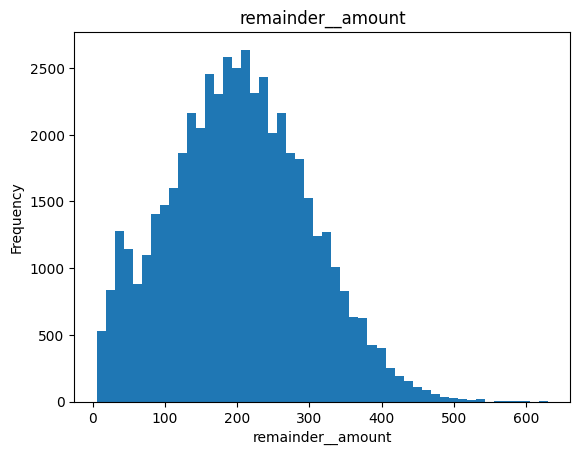

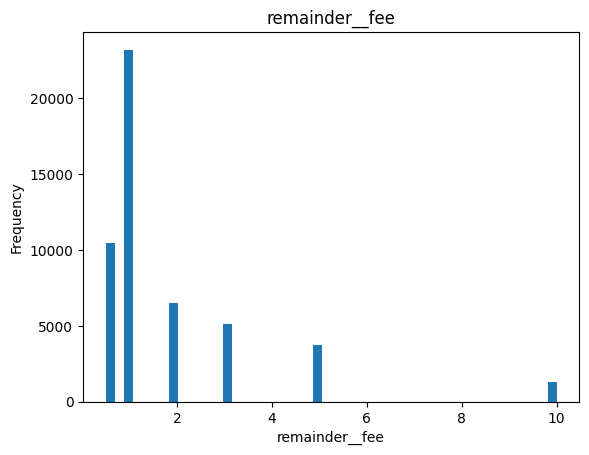

In [124]:
for col in ["remainder__amount", "remainder__fee"]:
    plt.figure()
    plt.hist(encoded_df[col].dropna(), bins=50)
    plt.title(col)              # Titel = Spaltenname
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()


Verteilung von amount ist fast symmetrisch, nur leichter Rechtsschweif.

Für die numerischen Spalten `remainder__amount` und `remainder__fee` wird eine Min-Max-Skalierung (`MinMaxScaler`) angewendet, um ihre Werte jeweils auf einen einheitlichen Bereich zwischen 0 und 1 zu transformieren. Diese Skalierung stellt sicher, dass Features mit potenziell großen Wertebereichen das Modelltraining nicht unverhältnismäßig beeinflussen. Die skalierten Ergebnisse werden in den neuen Spalten `remainder__amount_scaled` und `remainder__fee_scaled` gespeichert, während die ursprünglichen Werte erhalten bleiben = scaler.fit_transform(...)`, `encoded_df['remainder__fee_scaled'] = scaler.fit_transform(...)`].

In [125]:
scaler = MinMaxScaler(feature_range=(0, 1)) 

encoded_df['remainder__amount_scaled'] = scaler.fit_transform(
    encoded_df[['remainder__amount']]
)

# erweitern des encoded_df
encoded_df['remainder__fee_scaled'] = scaler.fit_transform(
    encoded_df[['remainder__fee']]
)

print(encoded_df[['remainder__amount', 'remainder__amount_scaled', 'remainder__fee', 'remainder__fee_scaled']].head())



  remainder__amount  remainder__amount_scaled remainder__fee  \
0                89                  0.133013            1.0   
1                89                  0.133013            3.0   
2               238                  0.371795            1.0   
3               238                  0.371795            3.0   
4               124                  0.189103            0.5   

   remainder__fee_scaled  
0               0.052632  
1               0.263158  
2               0.052632  
3               0.263158  
4               0.000000  


Der finale Datensatz besteht aus einer Kombination von kodierten kategorialen, binären, ordinalen und numerischen Features, die für das Modelltraining optimiert wurden.

* **One-Hot kodierte Features (`oh__`):**
    Dies sind die ursprünglichen kategorialen Merkmale, die in binäre (0/1) Spalten umgewandelt wurden, um eine künstliche Rangfolge zu vermeiden. Dazu gehören die aufgeschlüsselten Kategorien von `country`, `PSP`, `card`, `month` und `weekday`.

* **Binäre Features (`bin__`):**
    Dies sind Merkmale, die von Natur aus nur zwei Zustände (0 oder 1) haben. Diese Gruppe umfasst die Zielvariable `success` sowie die Merkmale `3D_secured` und `feiertag_DE`.

* **Ordinale Features (`ord__`):**
    Hierbei handelt es sich um Merkmale, die in Kategorien mit einer logischen Reihenfolge eingeteilt wurden. Dies sind `daytime` (Nacht < Morgen < Nachmittag < Abend), `amount_cat` (Q1 < Q2 < Q3 < Q4) und `calendar_week` (Woche 1 < 2 < ... < 9).

* **Numerische, zyklische und übrige Features (`remainder__`):**
    Diese Gruppe enthält eine Mischung aus ursprünglichen numerischen Werten, IDs und speziell aufbereiteten Zeitmerkmalen:
    * **Originalwerte:** `amount` und `fee`.
        * **Skalierte Werte:** `amount_scaled` und `fee_scaled`, die auf einen Bereich zwischen 0 und 1 transformiert wurden.
    * **Zyklische Zeitmerkmale:** Die ursprüngliche `hour`-Spalte wurde in zwei neue Merkmale, `hour_sin` und `hour_cos`, umgewandelt. Diese bilden den 24-stündigen Tageszyklus mathematisch ab und helfen dem Modell zu verstehen, dass Stunde 23 und Stunde 0 direkt aufeinanderfolgen.
    * **Sonstige Zeitmerkmale:** Der Original-Zeitstempel `tmsp` sowie die numerischen Werte `weekday_num` und `hour` bleiben erhalten.
    * **IDs:** Die `transactionId` zur Identifizierung zusammengehöriger Kaufversuche.

## gerundete Feststellungen über die Transaktionen

- 79.5% failed

- 60% Deutschland, 21 % Schweiz, 20 % Österreich
- 52% UK_Card, 25% SimpleCard,16% MoneyCard, 6% Goldcard
- 76% 3D secured
- 58% Master, 23% Visa, 19% Diners
- 52 % Januar, 48% Februar
- Monatg 14.5%, Dienstag 17.2%, Mittwoch 16.3%, Donnerstag 15.5%, Freitag 13.7%, Samstag 12.4%, Sonntag 10.5% 
- Rund um die Uhr je Stunde um 4% 
- Amount grob Normalverteilt , leichter rechtsschweif, Mittelwert 202 EUR, Median 201 EUR. Min 6 EUR, Max 630 EUR.


In [126]:
encoded_df.columns

Index(['oh__country_Austria', 'oh__country_Germany', 'oh__country_Switzerland',
       'oh__PSP_Goldcard', 'oh__PSP_Moneycard', 'oh__PSP_Simplecard',
       'oh__PSP_UK_Card', 'oh__card_Diners', 'oh__card_Master',
       'oh__card_Visa', 'oh__month_February', 'oh__month_January',
       'oh__weekday_Friday', 'oh__weekday_Monday', 'oh__weekday_Saturday',
       'oh__weekday_Sunday', 'oh__weekday_Thursday', 'oh__weekday_Tuesday',
       'oh__weekday_Wednesday', 'bin__success', 'bin__3D_secured',
       'bin__feiertag_DE', 'ord__daytime', 'ord__amount_cat',
       'ord__calendar_week', 'remainder__tmsp', 'remainder__amount',
       'remainder__transactionId', 'remainder__fee', 'remainder__weekday_num',
       'remainder__hour', 'remainder__hour_sin', 'remainder__amount_scaled',
       'remainder__fee_scaled'],
      dtype='object')

# Pkl speichern

In [127]:

# aktueller Skriptordner   …/scripts/save_pickle.py  (Beispiel)
this_dir = Path.cwd()         # …/data_preperation
data_dir   = this_dir / ".." / "Data"               # …/Data   
data_dir   = data_dir.resolve()                     # in absoluten Pfad umwandeln
data_dir.mkdir(exist_ok=True)                       # Ordner anlegen, falls noch nicht da
pkl_path   = data_dir / "encoded_scaled_df.pkl"     # …/Data/encoded_scaled_df.pkl

encoded_df.to_pickle(pkl_path)
#print(f"gespeichert in {pkl_path}")

